<a href="https://colab.research.google.com/github/kk-ddfafafa/AI/blob/master/DPPO_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# coding:utf-8
import gym
import numpy as np
import pandas as pd
import random
import os
import pdb

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving process_N225.csv to process_N225.csv


In [ ]:
import io
df = pd.read_csv(io.StringIO(uploaded['process_N225.csv'].decode('utf-8')), header=0,index_col = 0)
#df.drop(['Adj Close'], 1, inplace=True)
#df = df.iloc[:,[0,1,2,4,3]]

In [ ]:
df =  df.fillna(method = 'bfill')

In [ ]:
n = df.shape[0]
p = df.shape[1]

train_start=0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = df.iloc[:train_end,:]
data_test = df.iloc[test_start:test_end,:]

data_train = data_train.values 
data_test = data_test.values


# データの正規化
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train_norm = scaler.transform(data_train)
data_test_norm = scaler.transform(data_test)

In [ ]:
train = data_train_norm
test = data_test_norm
data = train
data_train[0:74,:].shape

(74, 7)

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import math

# position constant
LONG = 0
SHORT = 1
FLAT = 2

# action constant
BUY = 0
SELL = 1
HOLD = 2

class Env(gym.Env):
    
    def __init__(self,window_size,show_trade=True):
        self.show_trade = show_trade
        self.actions = ["LONG", "SHORT", "FLAT"]
        self.fee = 500
        self.seed()
        self.file_list = []
        self.df =data
        
        # n_features
        self.window_size = window_size
        self.n_features = self.df.shape[1]
        self.shape = (self.window_size, self.n_features+4)
        
        # defines action space
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

    def render(self, mode='human', verbose=False):
        return None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def step(self, action):

        if self.done:
            return self.state, self.reward, self.done, {}
        self.reward = 0
        
        self.action = HOLD  # hold
        
        if action == BUY: # buy
            if self.position == FLAT: # if previous position was flat
                self.position = LONG # update position to long
                self.action = BUY # record action as buy
                self.entry_price = self.closingPrice # maintain entry price
                self.wallet -= self.entry_price
                self.entry_tick = 0
#                print(self.entry_price,self.position)
            elif self.position == SHORT: # if previous position was short
                self.position = FLAT  # update position to flat
                self.action = BUY # record action as buy
                self.exit_price = self.closingPrice
                self.reward = self.entry_price - self.exit_price - self.fee
                self.wallet += self.closingPrice
                self.cumulative_return += self.reward 
                self.entry_price = 0 # clear entry price
                self.n_short += 1 # record number of short
#                print(str(self.closingPrice),str(self.reward),str(self.wallet))
        elif action == 1: # vice versa for short trade
            if self.position == FLAT:
                self.position = SHORT
                self.action = 1
                self.entry_price = self.closingPrice
                self.wallet -= self.entry_price
                self.entry_tick = 0
#                print(self.entry_price,self.position)
            elif self.position == LONG:
                self.position = FLAT
                self.action = 1
                self.exit_price = self.closingPrice
                self.reward = self.exit_price - self.entry_price - self.fee
                self.wallet += self.closingPrice
                self.cumulative_return += self.reward
                self.entry_price = 0
                self.n_long += 1
#                print(str(self.closingPrice),str(self.reward),str(self.wallet))
        

        # [coin + krw_won] total value evaluated in krw won
        if(self.position == LONG):
            temp_reward = self.closingPrice - self.entry_price - self.fee
            new_portfolio = self.wallet + self.closingPrice
        elif(self.position == SHORT):
            temp_reward = self.entry_price - self.closingPrice - self.fee
            new_portfolio = self.wallet + self.closingPrice
        else:
            temp_reward = 0
            new_portfolio = self.wallet

        self.portfolio = new_portfolio
        self.current_tick += 1
        self.entry_tick += 1
        if(self.show_trade and self.current_tick%100 == 0):
            print("Tick: {0}/ Wallet: {1}".format(self.current_tick, self.portfolio))
            print("Long: {0}/ Short: {1}".format(self.n_long, self.n_short))
        self.history.append((self.action, self.current_tick, self.closingPrice, self.portfolio, self.reward))
        self.updateState()
        if self.current_tick >= (len(data_train[:,0]) -1):
            self.done = True
            self.reward = self.get_profit() # return reward at end of the game
#        if self.portfolio < 0:
#            self.done = True;self.reward -= 1000000
#        print(self.portfolio,"                          ")
        if self.reward > 0:
            self.reward = 2 + self.reward/self.fee
        elif self.reward < 0:
            self.reward = -1
        
        return self.state, self.reward, self.done, {'portfolio':np.array([self.portfolio])}

    def get_profit(self):
        if(self.position == LONG):
            profit = self.closingPrice - self.entry_price - self.fee
        elif(self.position == SHORT):
            profit = self.entry_price - self.closingPrice - self.fee
        else:
            profit = 0
        return profit


    def reset(self):
        # self.current_tick = random.randint(0, self.df.shape[0]-1000)
        self.current_tick = 0
#        print("start episode ... {0} at {1}" .format(self.rand_episode, self.current_tick))

        # positions
        self.n_long = 0
        self.n_short = 0

        # clear internal variables
        self.history = [] # keep buy, sell, hold action history
        self.cumulative_return = 0 # initial balance, u can change it to whatever u like
        self.portfolio = float(self.cumulative_return) 
        self.profit = 0
        self.wallet = 500000
        self.entry_tick = 0# Forced settlement 

        
        self.action = HOLD
        self.position = FLAT
        self.done = False

        self.updateState() # returns observed_features +  opened position(LONG/SHORT/FLAT) + profit_earned(during opened position)
        return self.state

    def updateState(self):
        def one_hot_encode(x, n_classes):
            return np.eye(n_classes)[x]
        self.closingPrices = data_train[:,0]
        self.closingPrice = float(self.closingPrices[self.current_tick])
        prev_position = self.position
        one_hot_position = one_hot_encode(prev_position,3)
        profit = self.get_profit()
        # append two
        self.state = np.concatenate((self.df[self.current_tick], one_hot_position, [profit]))
        return self.state

In [ ]:
import keras
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Dropout
from keras.layers.normalization import BatchNormalization
from keras import Input, Sequential
from keras.optimizers import SGD
from keras.models import *
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


Tick: 100/ Wallet: 498636.19136
Long: 11/ Short: 12
Tick: 100/ Wallet: 498808.9609399999Tick: 100/ Wallet: 499308.8320400002
Long: 10/ Short: 8

Long: 12/ Short: 5
Tick: 100/ Wallet: 499922.9336
Long: 9/ Short: 13
Tick: 200/ Wallet: 498969.2001499999
Long: 20/ Short: 26
Tick: 200/ Wallet: 499558.43750000023Tick: 200/ Wallet: 496582.49022999994
Long: 17/ Short: 28

Long: 22/ Short: 11
Tick: 200/ Wallet: 497954.06934000005
Long: 18/ Short: 25
Tick: 300/ Wallet: 496662.3232499999
Long: 32/ Short: 22
Tick: 300/ Wallet: 499207.87208000023
Long: 28/ Short: 41
Tick: 300/ Wallet: 499175.8271099997
Long: 31/ Short: 33
Tick: 300/ Wallet: 498284.18163999985
Long: 32/ Short: 34
Tick: 400/ Wallet: 500852.3310700003
Long: 39/ Short: 53
Tick: 400/ Wallet: 497509.2597899999
Long: 44/ Short: 35
Tick: 400/ Wallet: 499432.9628899997
Long: 41/ Short: 46
Tick: 400/ Wallet: 500989.78615999996
Long: 44/ Short: 42
Tick: 500/ Wallet: 500984.01462000015
Long: 48/ Short: 69
Tick: 500/ Wallet: 498334.39842
Long: 

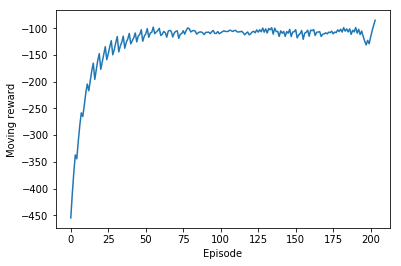

'\nおそらくテスト用だと思われる\n    while True:\n        s = env.reset()\n        for t in range(300):\n            #env.render()\n            s = env.step(GLOBAL_PPO.choose_action(s))[0]\n'

In [ ]:
import matplotlib.pyplot as plt
import threading, queue
import random
EP_MAX = 200
EP_LEN = len(data_train[:,0])
N_WORKER = 4                # parallel workers
GAMMA = 0.9                 # reward discount factor
A_LR = 0.0001               # learning rate for actor
C_LR = 0.0002               # learning rate for critic
MIN_BATCH_SIZE = 64         # minimum batch size for updating PPO
UPDATE_STEP = 20            # loop update operation n-steps
EPSILON = 0.2               # for clipping surrogate objective
GAME = 'Pendulum-v0'
S_DIM, A_DIM = 11, 1         # state and action dimension

envi = Env(1)
NUM_STATES = envi.observation_space.shape[0]     # CartPoleは4状態
NUM_ACTIONS = envi.action_space.n

# ε-greedyのパラメータ
EPS_START = 0.5
EPS_END = 0.0
EPS_STEPS = 200*N_WORKER


tf.reset_default_graph()
class PPO(object):
    def __init__(self):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, S_DIM], 'state')
        self.brain = Brain()
        # critic///Advantageの計算～Loss関数の定義
        l1 = tf.layers.dense(self.tfs, 300, tf.nn.relu)
        self.v = tf.layers.dense(l1, 1)
        self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
        self.advantage = self.tfdc_r - self.v#ここまでの4行はAdvantageを計算するためにある
        self.closs = tf.reduce_mean(tf.square(self.advantage))
        self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)#piという名前でスコープ。戻り値のpiは正規分布を、pi_paramsは重み変数を示している。
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        self.sample_op = tf.squeeze(pi.sample(1), axis=0)  # operation of choosing action
        self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
        ratio = pi.prob(self.tfa) / (oldpi.prob(self.tfa) + 1e-5)
        surr = ratio * self.tfadv                       # surrogate loss

        self.aloss = -tf.reduce_mean(tf.minimum(        # clipped surrogate objective
            surr,
            tf.clip_by_value(ratio, 1. - EPSILON, 1. + EPSILON) * self.tfadv))

        self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)
        self.sess.run(tf.global_variables_initializer())



    def update(self):
        global GLOBAL_UPDATE_COUNTER
        while not COORD.should_stop():
            if GLOBAL_EP < EP_MAX:
                UPDATE_EVENT.wait()                     # wait until get batch of data
                self.sess.run(self.update_oldpi_op)     # copy pi to old pi
                data = [QUEUE.get() for _ in range(QUEUE.qsize())]      # collect data from all workers
                data = np.vstack(data)
                s, a, r = data[:, :S_DIM], data[:, S_DIM: S_DIM + A_DIM], data[:, -1:]
                adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})
                # update actor and critic in a update loop
                [self.sess.run(self.atrain_op, {self.tfs: s, self.tfa: a, self.tfadv: adv}) for _ in range(UPDATE_STEP)]
                [self.sess.run(self.ctrain_op, {self.tfs: s, self.tfdc_r: r}) for _ in range(UPDATE_STEP)]
                UPDATE_EVENT.clear()        # updating finished
                GLOBAL_UPDATE_COUNTER = 0   # reset counter
                ROLLING_EVENT.set()         # set roll-out available

    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.tfs, 200, tf.nn.relu, trainable=trainable)
            mu = 2 * tf.layers.dense(l1, A_DIM, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(l1, A_DIM, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)#正規分布
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)#重みの変数を定義している
        return norm_dist, params

    def choose_action(self, s):#########################################################################################################################################################
        if ep_r >= EPS_STEPS:   # ε-greedy法で行動を決定します
            eps = EPS_END
        else:
            eps = EPS_START + ep_r * (EPS_END - EPS_START) / EPS_STEPS  # linearly interpolate

        if random.random() < eps:
            return random.randint(0, NUM_ACTIONS - 1)   # ランダムに行動
        else:
            s = np.array([s])
            p = self.brain.predict_p(s)
            a = np.random.choice(NUM_ACTIONS, p=p[0])
        return a

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0, 0]
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class Brain:
    def __init__(self):   # globalなparameter_serverをメンバ変数として持つ
        self.model = self._build_model()  # ニューラルネットワークの形を決定
        K.set_session(SESS)
    def _build_model(self):     # Kerasでネットワークの形を定義します
        l_input = Input(batch_shape=(None, S_DIM))
        l_dense = Dense(16, activation='relu')(l_input)
        out_actions = Dense(NUM_ACTIONS, activation='softmax')(l_dense)
        out_value = Dense(1, activation='linear')(l_dense)
        model = Model(inputs=[l_input], outputs=[out_actions, out_value])
        model._make_predict_function()  # have to initialize before threading
        plot_model(model, to_file='PPO.png', show_shapes=True)  # Qネットワークの可視化
        return model

    def predict_p(self, s):    # 状態sから各actionの確率pベクトルを返します
        p, v = self.model.predict(s)
        return p

class Worker(object):
    def __init__(self, wid):
        self.wid = wid
        self.env = Env(75)#gym.make(GAME).unwrapped
        self.ppo = GLOBAL_PPO
    def work(self):
        global GLOBAL_EP, GLOBAL_RUNNING_R, GLOBAL_UPDATE_COUNTER,ep_r
        while not COORD.should_stop():
            s = self.env.reset()
            ep_r = 0
            buffer_s, buffer_a, buffer_r = [], [], []
            for t in range(EP_LEN):
                if not ROLLING_EVENT.is_set():                  # while global PPO is updating
                    ROLLING_EVENT.wait()                        # wait until PPO is updated
                    buffer_s, buffer_a, buffer_r = [], [], []   # clear history buffer, use new policy to collect data

                a = self.ppo.choose_action(s)
                s_, r, done, _ = self.env.step(a)
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)                    # normalize reward, find to be useful
                s = s_
                ep_r += r

                GLOBAL_UPDATE_COUNTER += 1                      # count to minimum batch size, no need to wait other workers
                if t == EP_LEN - 1 or GLOBAL_UPDATE_COUNTER >= MIN_BATCH_SIZE:
                    _,v_s_ = self.ppo.brain.model.predict(s[np.newaxis, :])#self.ppo.get_v(s_)
                    v_s_ = v_s_[0,0]
                    discounted_r = []                           # compute discounted reward
                    for r in buffer_r[::-1]:
                        v_s_ = r + GAMMA * v_s_
                        discounted_r.append(v_s_)
                    discounted_r.reverse()

                    bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
                    buffer_s, buffer_a, buffer_r = [], [], []
                    QUEUE.put(np.hstack((bs, ba, br)))          # put data in the queue
                    if GLOBAL_UPDATE_COUNTER >= MIN_BATCH_SIZE:
                        ROLLING_EVENT.clear()       # stop collecting data
                        UPDATE_EVENT.set()          # globalPPO update

                    if GLOBAL_EP >= EP_MAX:         # stop training
                        COORD.request_stop()
                        break

            # record reward changes, plot later
            if len(GLOBAL_RUNNING_R) == 0: GLOBAL_RUNNING_R.append(ep_r)
            else: GLOBAL_RUNNING_R.append(GLOBAL_RUNNING_R[-1]*0.9+ep_r*0.1)
            GLOBAL_EP += 1
            print('{0:.1f}%'.format(GLOBAL_EP/EP_MAX*100), '|W%i' % self.wid,  '|Ep_r: %.2f' % ep_r,)


if __name__ == '__main__':
    env = Env(1);env.reset()
    SESS = tf.Session()
    GLOBAL_PPO = PPO()
    UPDATE_EVENT, ROLLING_EVENT = threading.Event(), threading.Event()
    UPDATE_EVENT.clear()            # not update now
    ROLLING_EVENT.set()             # start to roll out
    workers = [Worker(wid=i) for i in range(N_WORKER)]
    
    GLOBAL_UPDATE_COUNTER, GLOBAL_EP = 0, 0
    GLOBAL_RUNNING_R = []
    COORD = tf.train.Coordinator()
    SESS.run(tf.global_variables_initializer()) # 変数を初期化
    QUEUE = queue.Queue()           # workers putting data in this queue
    threads = []
    for worker in workers:          # worker threads
        t = threading.Thread(target=worker.work, args=(), daemon=True)
        t.start()                   # training
        threads.append(t)
    # add a PPO updating thread
    threads.append(threading.Thread(target=GLOBAL_PPO.update,))
    threads[-1].start()
    COORD.join(threads)
    # plot reward change and test
    plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
    plt.xlabel('Episode'); plt.ylabel('Moving reward'); plt.ion(); plt.show()
"""
おそらくテスト用だと思われる
    while True:
        s = env.reset()
        for t in range(300):
            #env.render()
            s = env.step(GLOBAL_PPO.choose_action(s))[0]
"""